**AI Job Market Assistant**

## API Keys Setup
Setting up environment variables for OpenAI API access. The system loads API keys from environment variables for secure access to language models.

In [244]:
import os
# from getpass import getpass
from dotenv import load_dotenv
load_dotenv()
# os.environ["OPENAI_API_KEY"] = getpass("Please enter your OpenAI API key!")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

## Additional API Keys
Configuring Tavily (web search) and Cohere (reranking) API keys for enhanced search and document ranking capabilities.

In [245]:
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

## Additional API Configuration
Setting up Cohere API key for reranking capabilities and additional service integrations.

In [246]:
os.environ["COHERE_API_KEY"] = os.getenv("COHERE_API_KEY")

## LangSmith Tracing Setup
Enabling LangSmith for monitoring and debugging LangChain operations. This helps track agent performance and tool usage during execution.

In [247]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AI Job Market Assistant - {uuid4().hex[0:8]}"
# os.environ["LANGCHAIN_API_KEY"] = getpass("LangSmith API Key: ")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

## Data Directory Setup
Creating data directory and checking for the job dataset file. This ensures the required CSV file exists before proceeding with data loading.

In [248]:
# Ensure data directory exists
!mkdir -p data

# Check if job dataset exists
import os
if not os.path.exists("data/job_dataset.csv"):
    print("Warning: job_dataset.csv not found in data directory")
    print("Please ensure you have a CSV file with AI job market data")
else:
    print("Found job_dataset.csv - ready to load data")

Found job_dataset.csv - ready to load data


## Data Loading and Processing
Loading AI job market dataset from CSV file, limiting to 1000 rows for faster processing, and converting to LangChain documents for RAG system.

In [249]:
from langchain_community.document_loaders import CSVLoader
import pandas as pd

# Load only the first 5000 rows
df = pd.read_csv("data/job_dataset.csv", nrows=1000)
df.to_csv("data/job_dataset_5k.csv", index=False)

# Load the specific CSV file
csv_file_path = "data/job_dataset_5k.csv"
loader = CSVLoader(file_path=csv_file_path)
docs = loader.load()

## External Tools Setup
Configuring external tools for enhanced search capabilities:
- **Tavily**: Web search for current job market trends
- **ArXiv**: Academic paper search for research insights

In [250]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.arxiv.tool import ArxivQueryRun

tavily_tool = TavilySearchResults(max_results=5)
arxiv_tool = ArxivQueryRun()

## Text Splitting for Vector Storage
Breaking down documents into smaller chunks (1000 chars with 200 overlap) to optimize vector search performance and retrieval accuracy.

In [251]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
split_documents = text_splitter.split_documents(docs)
len(split_documents)


1000

## Embeddings Model Setup
Initializing OpenAI's text-embedding-3-small model for converting text into numerical vectors for similarity search.

In [252]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

## Populating Vector Database
Adding all document chunks to the vector store in batches of 50. This process creates searchable embeddings for the entire job dataset with progress tracking.

In [253]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="job_market_data",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="job_market_data",
    embedding=embeddings,
)

## Retriever Configuration
Setting up the vector store as a retriever to find the top 5 most relevant documents for any given query.

In [254]:
import time
print(f"Starting to add {len(split_documents)} documents to vector store...")
start_time = time.time()

# Add documents in batches to show progress
batch_size = 50
total_docs = len(split_documents)

if total_docs > 0:
    for i in range(0, total_docs, batch_size):
        batch = split_documents[i:i+batch_size]
        batch_num = (i // batch_size) + 1
        total_batches = (total_docs + batch_size - 1) // batch_size
        
        print(f"Processing batch {batch_num}/{total_batches} ({len(batch)} documents)...")
        vector_store.add_documents(documents=batch)
        
        elapsed = time.time() - start_time
        print(f"Batch {batch_num} completed. Elapsed time: {elapsed:.1f}s")
    
    total_time = time.time() - start_time
    print(f"✅ All documents added successfully! Total time: {total_time:.1f}s")
else:
    print("⚠️ No documents to add to vector store")

Starting to add 1000 documents to vector store...
Processing batch 1/20 (50 documents)...
Batch 1 completed. Elapsed time: 0.9s
Processing batch 2/20 (50 documents)...
Batch 2 completed. Elapsed time: 1.6s
Processing batch 3/20 (50 documents)...
Batch 3 completed. Elapsed time: 2.3s
Processing batch 4/20 (50 documents)...
Batch 4 completed. Elapsed time: 3.0s
Processing batch 5/20 (50 documents)...
Batch 5 completed. Elapsed time: 3.7s
Processing batch 6/20 (50 documents)...
Batch 6 completed. Elapsed time: 4.5s
Processing batch 7/20 (50 documents)...
Batch 7 completed. Elapsed time: 5.5s
Processing batch 8/20 (50 documents)...
Batch 8 completed. Elapsed time: 6.1s
Processing batch 9/20 (50 documents)...
Batch 9 completed. Elapsed time: 6.7s
Processing batch 10/20 (50 documents)...
Batch 10 completed. Elapsed time: 7.4s
Processing batch 11/20 (50 documents)...
Batch 11 completed. Elapsed time: 8.3s
Processing batch 12/20 (50 documents)...
Batch 12 completed. Elapsed time: 9.4s
Processi

In [255]:
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

## Retriever Configuration
Setting up the vector store as a retriever to find the top 5 most relevant documents for any given query.

In [256]:
def retrieve(state):
    """Simple retrieve function without reranking."""
    retrieved_docs = retriever.invoke(state["question"])
    return {"context": retrieved_docs}

## Basic RAG Functions
Creating simple retrieve and generate functions for the baseline RAG system without any advanced reranking.

## RAG Pipeline - Basic Version
Creating the first version of our RAG (Retrieval-Augmented Generation) system with:
- Simple document retrieval
- Context-based response generation
- LangGraph workflow orchestration

## RAG Prompt Template
Defining the prompt template that instructs the LLM to answer questions based only on provided context without using external knowledge.

In [257]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """
You are a helpful assistant who answers questions based on provided context. You must only use the provided context, and cannot use any other information.

### Question
{question}

### Context
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

## Language Model Setup
Initializing the OpenAI GPT model for generating responses in the RAG pipeline.

In [258]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-nano")

## RAG State Definition
Defining the state schema for the RAG pipeline using TypedDict to track questions, context documents, and responses.

In [259]:
def generate(state):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = rag_prompt.format_messages(question=state["question"], context=docs_content)
    response = llm.invoke(messages)
    return {"response": response.content}

## Basic RAG Graph Setup
Building and compiling the basic RAG workflow using LangGraph with retrieve → generate sequence.

In [260]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class State(TypedDict):
    question: str
    context: List[Document]
    response: str

## Testing Basic RAG
Testing the basic RAG system with a sample question about AI job skills to verify functionality.

In [261]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

## RAG Tool Creation
Converting the RAG pipeline into a tool that can be used by the multi-agent system for job market queries.

## Multi-Agent System Setup
Building an intelligent agent system that can:
- Use multiple tools (RAG, web search, academic search)
- Route queries to appropriate tools
- Combine information from multiple sources

## Tool Belt Assembly
Creating a collection of tools (RAG, Tavily web search, ArXiv search) for the multi-agent system to use.

In [262]:
response = graph.invoke({"question" : "What are the top AI job skills in demand?"})

## Agent Model Configuration
Setting up the main language model (GPT-4o) for the agent and binding it with the available tools.

In [263]:
response["response"]

'The top AI job skills in demand are NLP, Scala, Statistics, AWS, Deep Learning, Spark, Kubernetes, Python, Azure, and Git.'

## Agent State Definition
Defining the agent state schema to track conversation messages and context documents throughout the workflow.

In [264]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage

@tool
def ai_job_rag_tool(question: str) -> str:
    """Useful for when you need to answer questions about AI job market, skills, salaries, or career advice. Input should be a fully formed question."""
    response = graph.invoke({"question": question})
    return {
        "messages": [HumanMessage(content=response["response"])],
        "context": response["context"],
    }

## Agent Functions Setup
Creating the main agent function and tool node for handling model calls and tool executions in the workflow.

In [265]:
tool_belt = [
    tavily_tool,
    arxiv_tool,
    ai_job_rag_tool,
]

## Agent Graph Construction
Building the multi-agent graph structure with agent and action nodes for intelligent tool routing.

In [266]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o", temperature=0)

## Agent Entry Point
Setting the agent as the entry point for all incoming queries in the multi-agent system.

In [267]:
model = model.bind_tools(tool_belt)

## Conditional Logic Setup
Implementing conditional edges that determine whether to continue with tool calls or end the conversation.

In [268]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.documents import Document

class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    context: list[Document]


## Agent Workflow Completion
Adding the final edge from actions back to agent and compiling the complete multi-agent system.

In [269]:
from langgraph.prebuilt import ToolNode

def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    return {
        "messages": [response],
        "context": state.get("context", []),
    }

tool_node = ToolNode(tool_belt)

## Agent Testing - High Paying Jobs
Testing the multi-agent system with a query about highest paying AI jobs to demonstrate tool routing and response generation.

In [270]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)
uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

## Agent Testing - ArXiv Research
Testing the agent's ability to search academic papers on ArXiv for AI job market research and trends.

In [271]:
uncompiled_graph.set_entry_point("agent")

## Agent Testing - Salary Query
Testing the agent with a salary question to verify the RAG tool integration and response accuracy.

In [272]:
def should_continue(state):
    last_message = state["messages"][-1]

    if last_message.tool_calls:
        return "action"
    
    return END

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)

## Evaluation Dataset Generation
Creating test questions and reference answers using RAGAS framework to systematically evaluate our AI assistant's performance on job market queries.

In [273]:
uncompiled_graph.add_edge("action", "agent")

## Generated Dataset Preview
Displaying the generated evaluation dataset with test questions, reference contexts, and expected answers for system validation.

## Agent Graph Compilation
Compiling the multi-agent graph with tool routing capabilities for production use.

## Context Parser Implementation
Implementing a comprehensive parser to extract and organize context from different tool responses (Tavily, ArXiv, RAG) for evaluation.

In [274]:
compiled_graph = uncompiled_graph.compile()

In [275]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="What are the highest paying AI jobs in 2025?")]}

async for chunk in compiled_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: {node}")
        print(values["messages"])
    print("\n\n")

Receiving update from node: agent
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bnRwnfsG5KQlSGsgY1QPFWY5', 'function': {'arguments': '{"question":"What are the highest paying AI jobs in 2025?"}', 'name': 'ai_job_rag_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 210, 'total_tokens': 238, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-C0BJKJhVT88eBwo9DvjMNQ2ZQ645Q', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b2feedca-d435-44e9-bc07-cacfb0131492-0', tool_calls=[{'name': 'ai_job_rag_tool', 'args': {'question': 'What are the highest paying AI jobs in 2025?'}, 'id': 'call_bnRwnfsG5KQlSGsgY1QPFWY5', 'type

In [276]:
inputs = {"messages": [HumanMessage(content="Search Arxiv for papers on AI job market trends and skill requirements")]}

async for chunk in compiled_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: {node}")
        if node == "action":
            print(f"Tool Used: {values['messages'][0].name}")
        print(values["messages"])
        
        print("\n\n")

Receiving update from node: agent
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_RUqHntp7KBn4PBkzZ4Jn1DGp', 'function': {'arguments': '{"query":"AI job market trends and skill requirements"}', 'name': 'arxiv'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 211, 'total_tokens': 231, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-C0BJO7RJCeSw5bSUbv4xD7eJnWI9U', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8a363a91-54ee-4f1c-a0a5-8a6c4c4aed78-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'AI job market trends and skill requirements'}, 'id': 'call_RUqHntp7KBn4PBkzZ4Jn1DGp', 'type': 'tool_call'}], usage_meta

In [277]:
inputs = {"messages": [HumanMessage(content="What is the average salary for an AI engineer?")]}

async for chunk in compiled_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: {node}")
        if node == "action":
            print(f"Tool Used: {values['messages'][0].name}")
        print(values["messages"])
        
        print("\n\n")

Receiving update from node: agent
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nWyzIdKz0NOpgLfPifgGsiMk', 'function': {'arguments': '{"question":"What is the average salary for an AI engineer?"}', 'name': 'ai_job_rag_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 208, 'total_tokens': 234, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-C0BJXn3BriuDMQ8VX0GvuPpfH4gjR', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e5b653c2-dd50-4f0a-ad76-a463042aeb6d-0', tool_calls=[{'name': 'ai_job_rag_tool', 'args': {'question': 'What is the average salary for an AI engineer?'}, 'id': 'call_nWyzIdKz0NOpgLfPifgGsiMk', '

In [278]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [279]:
import pandas as pd
import os
from ragas.testset import TestsetGenerator

# Use simple static cache filename for job market dataset
cache_file = "job_market_dataset_cache.json"

if os.path.exists(cache_file):
    print(f"Loading cached dataset from {cache_file}...")
    cached_df = pd.read_json(cache_file)
    from ragas import EvaluationDataset
    dataset = EvaluationDataset.from_pandas(cached_df)
    print(f"Loaded {len(dataset)} test samples from cache")
else:
    print("Generating new dataset...")
    generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
    dataset = generator.generate_with_langchain_docs(docs[:50], testset_size=10)
    
    print(f"Caching dataset to {cache_file}...")
    dataset.to_pandas().to_json(cache_file, orient='records', indent=2)
    print(f"Generated and cached {len(dataset)} test samples")

Loading cached dataset from job_market_dataset_cache.json...
Loaded 10 test samples from cache


In [280]:
dataset.to_pandas()

,user_input,reference_contexts,reference
0,As an aspiring data engineer interested in the...,[job_id: AI00001\njob_title: AI Research Scien...,The position at Smart Analytics is within the ...
1,"As an aspiring data engineer, how is AWS relev...",[job_id: AI00002\njob_title: AI Software Engin...,In the context of the AI Software Engineer pos...
2,What is the required education for the AI Spec...,[job_id: AI00003\njob_title: AI Specialist\nsa...,The required education for the AI Specialist r...
3,What are the oppurtunities at Future Systems f...,[job_id: AI00004\njob_title: NLP Engineer\nsal...,The context provides information about a job p...
4,France job?,[job_id: AI00005\njob_title: AI Consultant\nsa...,The job is located in France at Advanced Robot...
5,Wht is the job in Austrailia that requiers ski...,[<1-hop>\n\njob_id: AI00028\njob_title: Data A...,The job in Austrailia is for a ML Ops Engineer...
6,Considering the roles of a Research Scientist ...,[<1-hop>\n\njob_id: AI00032\njob_title: Resear...,Both the Research Scientist position at Cloud ...
7,Considering the opportunities available in Ind...,[<1-hop>\n\njob_id: AI00027\njob_title: ML Ops...,The ML Ops Engineer position at TechCorp Inc i...
8,Considering the roles of a ML Ops Engineer at ...,[<1-hop>\n\njob_id: AI00045\njob_title: ML Ops...,Proficiency in Docker is crucial for both the ...
9,so if i want to be a data scientist in real es...,[<1-hop>\n\njob_id: AI00032\njob_title: Resear...,"Based on the context, if you want to be a data..."


In [281]:
import json
from typing import Dict, List, Optional, Union, Any
import re
import ast

class ContextParser:
    """Parser for extracting and organizing context from conversation messages."""

    @staticmethod
    def detect_tool_type(message: Any) -> Optional[str]:
        """Detect the tool type from the message."""
        try:
            if hasattr(message, 'name'):
                print(f"Found tool name: {message.name}")
                if 'tavily' in message.name.lower():
                    return 'tavily'
                elif 'ai_rag' in message.name.lower():
                    return 'ai_rag'
                elif 'arxiv' in message.name.lower():
                    return 'arxiv'
            return None
        except Exception as e:
            print(f"Error detecting tool type: {str(e)}")
            return None

    @staticmethod
    def extract_content(message: Any) -> Optional[str]:
        """Extract content from a message object."""
        try:
            if hasattr(message, 'content'):
                content = message.content
                if isinstance(content, str):
                    # Handle different content formats
                    if content.startswith('content="') or content.startswith("content='"):
                        # Extract content between quotes
                        quote_char = '"' if content.startswith('content="') else "'"
                        start_idx = len(f'content={quote_char}')
                        # Find the last occurrence of the quote before ' name='
                        if ' name=' in content:
                            end_idx = content.rfind(quote_char, start_idx, content.index(' name='))
                            return content[start_idx:end_idx]
                        else:
                            # If no ' name=' found, find the last quote
                            end_idx = content.rfind(quote_char)
                            return content[start_idx:end_idx]
                    return content
                elif isinstance(content, list):
                    # If content is a list, convert to string
                    return json.dumps(content)
            return None     
        except Exception as e:
            print(f"Error extracting content: {str(e)}")
            return None
        
    @staticmethod
    def parse_tavily_results(content: str) -> List[Dict]:
        """Parse Tavily search results from content string."""
        try:
            # Handle different content formats
            if isinstance(content, str):
                # Try to parse as JSON first
                try:
                    data = json.loads(content)
                except:
                    # If not valid JSON, try to extract JSON from the string
                    json_match = re.search(r'\[.*\]', content, re.DOTALL)
                    if json_match:
                        data = json.loads(json_match.group())
                    else:
                        return []
            else:
                data = content
                
            # Get results array from the appropriate location
            if isinstance(data, list):
                results = data
            elif isinstance(data, dict):
                if 'artifact' in data and 'results' in data['artifact']:
                    results = data['artifact']['results']
                elif 'results' in data:
                    results = data['results']
                else:
                    results = []
            else:
                results = []
                
            # Process and clean results
            cleaned_results = []
            for result in results:
                if isinstance(result, dict):
                    content_text = result.get('content', '')
                    if isinstance(content_text, dict):
                        content_text = str(content_text)
                    if content_text:  # Only add if content is not empty
                        cleaned_results.append({
                            'content': content_text,
                            'url': result.get('url', ''),
                            'title': result.get('title', '')
                        })
            
            return cleaned_results
        except Exception as e:
            print(f"Error parsing Tavily results: {str(e)}")
            return []

    @staticmethod
    def parse_ai_rag_results(content: str) -> List[Dict]:
        """Parse AI RAG tool results from content string."""
        try:
            # First check if content contains the expected Document format
            if 'Document(' not in content and 'page_content' not in content:
                # Try to extract just the response message
                if 'HumanMessage' in content:
                    msg_match = re.search(r"content='([^']+)'", content)
                    if msg_match:
                        return [{'content': msg_match.group(1)}]
                return []
            
            # Clean up the content string
            content = content.replace('\\\\', '\\')
            content = content.replace('\\n', '\n')
            
            # Extract all Document entries
            documents = []
            
            # Pattern to match Document(metadata={...}, page_content='...')
            doc_pattern = r"Document\(metadata=({[^}]+}),\s*page_content='([^']+)'"
            matches = re.finditer(doc_pattern, content)
            
            for match in matches:
                try:
                    metadata_str = match.group(1)
                    page_content = match.group(2)
                    
                    # Clean up metadata for JSON parsing
                    metadata_str = metadata_str.replace("'", '"')
                    metadata = json.loads(metadata_str)
                    
                    if page_content.strip():  # Only add if content is not empty
                        documents.append({
                            'source': metadata.get('source', 'AI RAG'),
                            'content': page_content,
                            'score': metadata.get('relevance_score', metadata.get('score', 1.0))
                        })
                except Exception as e:
                    print(f"Error parsing individual document: {str(e)}")
                    continue
                    
            print(f"Successfully parsed {len(documents)} AI RAG documents")
            return documents

        except Exception as e:
            print(f"Error parsing AI RAG results: {str(e)}")
            return []

    @staticmethod
    def parse_arxiv_results(content: str) -> List[Dict]:
        """Parse arxiv results from content string."""
        try:
            papers = []
            
            # Check if content is empty or too short
            if not content or len(content.strip()) < 10:
                return []
            
            # Split by common arxiv result delimiters
            sections = re.split(r'(?=Published: \d{4})', content)
            
            for section in sections:
                if not section.strip() or len(section) < 20:
                    continue

                # Extract paper details with more flexible patterns
                date_match = re.search(r'Published: (\d{4}-\d{2}-\d{2})', section)
                title_match = re.search(r'Title: ([^\n]+)', section)
                authors_match = re.search(r'Authors: ([^\n]+)', section)
                summary_match = re.search(r'Summary: (.+?)(?=Published:|$)', section, re.DOTALL)

                if title_match and (summary_match or authors_match):
                    summary_text = summary_match.group(1).strip() if summary_match else ''
                    
                    if summary_text or (title_match and authors_match):  # Accept if we have summary OR title+authors
                        paper = {
                            'date': date_match.group(1) if date_match else 'Unknown',
                            'title': title_match.group(1).strip(),
                            'authors': authors_match.group(1).strip() if authors_match else 'Unknown',
                            'summary': summary_text if summary_text else f"Paper by {authors_match.group(1).strip() if authors_match else 'Unknown'}"
                        }
                        papers.append(paper)

            return papers
        except Exception as e:
            print(f"Error parsing arXiv results: {str(e)}")
            return []

def parse_tool_call(message: Any) -> List[Dict]:
    """Parse tool call results from a conversation message."""
    parser = ContextParser()

    print("\n=== Starting message parsing ===")
    print(f"Message type: {type(message)}")

    # Detect tool type
    tool_type = parser.detect_tool_type(message)
    print(f"Detected tool type: {tool_type}")

    if tool_type is None:
        print("Could not detect tool type")
        return []

    # Extract content
    content = parser.extract_content(message)
    if content is None:
        print("Could not extract content")
        return []

    print(f"Extracted content length: {len(content) if content else 0}")

    # Parse based on tool type
    results = []
    if tool_type == 'tavily':
        results = parser.parse_tavily_results(content)
        print(f"Parsed {len(results)} Tavily results")
    elif tool_type == 'ai_rag':
        results = parser.parse_ai_rag_results(content)
        print(f"Parsed {len(results)} AI RAG results")
    elif tool_type == 'arxiv':
        results = parser.parse_arxiv_results(content)
        print(f"Parsed {len(results)} arXiv results")

    return results

In [283]:
for idx, test_row in enumerate(dataset):
    print(f"\n\nProcessing row {idx}: {test_row.user_input[:50]}...")
    
    inputs = {"messages": [HumanMessage(content=test_row.user_input)]}
    response = compiled_graph.invoke(inputs)
    test_row.response = response["messages"][-1].content

    # Initialize with empty list
    test_row.retrieved_contexts = []
    
    # Find all ToolMessages in the response
    tool_messages = []
    for msg in response["messages"]:
        # Check if it's a ToolMessage by looking for the 'name' attribute
        if hasattr(msg, 'name') and msg.name is not None:
            tool_messages.append(msg)
            print(f"Found tool message: {msg.name}")
    
    # Process all tool messages to gather contexts
    all_contexts = []
    for tool_message in tool_messages:
        results = parse_tool_call(tool_message)
        
        # Extract only the text content from the results if we have any
        if results:
            if isinstance(results[0], dict):
                # For Tavily and AI RAG results
                if 'content' in results[0]:
                    contexts = [r['content'] for r in results if r.get('content')]
                    all_contexts.extend(contexts)
                # For arXiv results
                elif 'summary' in results[0]:
                    contexts = [r['summary'] for r in results if r.get('summary')]
                    all_contexts.extend(contexts)
            else:
                # If results are already strings
                all_contexts.extend([r for r in results if r])
    
    # Use all collected contexts
    if all_contexts:
        test_row.retrieved_contexts = all_contexts
        print(f"Total contexts collected: {len(all_contexts)}")
    else:
        # Fallback: If no contexts found, use the response itself as context
        print("WARNING: No contexts found, using response as fallback")
        test_row.retrieved_contexts = [test_row.response]
    
    print(f"Final context count for row {idx}: {len(test_row.retrieved_contexts)}")



Processing row 0: As an aspiring data engineer interested in the aut...
Found tool message: ai_job_rag_tool
Found tool message: tavily_search_results_json

=== Starting message parsing ===
Message type: <class 'langchain_core.messages.tool.ToolMessage'>
Found tool name: ai_job_rag_tool
Detected tool type: None
Could not detect tool type

=== Starting message parsing ===
Message type: <class 'langchain_core.messages.tool.ToolMessage'>
Found tool name: tavily_search_results_json
Detected tool type: tavily
Extracted content length: 6666
Parsed 5 Tavily results
Total contexts collected: 5
Final context count for row 0: 5


Processing row 1: As an aspiring data engineer, how is AWS relevant ...
Found tool message: ai_job_rag_tool

=== Starting message parsing ===
Message type: <class 'langchain_core.messages.tool.ToolMessage'>
Found tool name: ai_job_rag_tool
Detected tool type: None
Could not detect tool type
Final context count for row 1: 1


Processing row 2: What is the required educa

## Evaluation Setup
Setting up RAGAS evaluation framework with LLM wrappers for systematic assessment of the AI assistant's performance.

In [284]:
# Debug: Let's examine the actual tool message structure for one example
test_input = "What skills do I need to become a data scientist?"
inputs = {"messages": [HumanMessage(content=test_input)]}
response = compiled_graph.invoke(inputs)

print("=== Response Messages ===")
for i, msg in enumerate(response["messages"]):
    print(f"\nMessage {i}: {type(msg).__name__}")
    if hasattr(msg, 'content'):
        print(f"Content preview: {str(msg.content)[:200]}...")
    if hasattr(msg, 'name'):
        print(f"Tool name: {msg.name}")
    if hasattr(msg, 'tool_calls'):
        print(f"Has tool calls: {msg.tool_calls}")

=== Response Messages ===

Message 0: HumanMessage
Content preview: What skills do I need to become a data scientist?...
Tool name: None

Message 1: AIMessage
Content preview: ...
Tool name: None
Has tool calls: [{'name': 'ai_job_rag_tool', 'args': {'question': 'What skills do I need to become a data scientist?'}, 'id': 'call_8cKDTPm53SxvG5kqdQWXMSZF', 'type': 'tool_call'}]

Message 2: ToolMessage
Content preview: {'messages': [HumanMessage(content='To become a data scientist, the required skills include Python, GCP (Google Cloud Platform), Scala, Tableau, and Git.', additional_kwargs={}, response_metadata={})]...
Tool name: ai_job_rag_tool

Message 3: AIMessage
Content preview: To become a data scientist, you should focus on developing the following skills:

1. **Programming Languages**: Proficiency in Python and R is essential for data manipulation and analysis.
2. **Data V...
Tool name: None
Has tool calls: []


## Enhanced RAG with Cohere Reranking
Implementing an improved version of our RAG system using Cohere's rerank-v3.5 model to better prioritize retrieved documents for more accurate responses.

In [285]:
for idx, test_row in enumerate(dataset):
    print(f"\n\nProcessing row {idx}: {test_row.user_input[:50]}...")
    
    inputs = {"messages": [HumanMessage(content=test_row.user_input)]}
    response = compiled_graph.invoke(inputs)
    test_row.response = response["messages"][-1].content

    # Initialize with empty list
    test_row.retrieved_contexts = []
    
    # Find all ToolMessages in the response
    tool_messages = []
    for msg in response["messages"]:
        # Check if it's a ToolMessage by looking for the 'name' attribute
        if hasattr(msg, 'name') and msg.name is not None:
            tool_messages.append(msg)
            print(f"Found tool message: {msg.name}")
    
    # Process all tool messages to gather contexts
    all_contexts = []
    for tool_message in tool_messages:
        results = parse_tool_call(tool_message)
        
        # Extract only the text content from the results if we have any
        if results:
            if isinstance(results[0], dict):
                # For Tavily and AI RAG results
                if 'content' in results[0]:
                    contexts = [r['content'] for r in results if r.get('content')]
                    all_contexts.extend(contexts)
                # For arXiv results
                elif 'summary' in results[0]:
                    contexts = [r['summary'] for r in results if r.get('summary')]
                    all_contexts.extend(contexts)
            else:
                # If results are already strings
                all_contexts.extend([r for r in results if r])
    
    # Use all collected contexts
    if all_contexts:
        test_row.retrieved_contexts = all_contexts
        print(f"Total contexts collected: {len(all_contexts)}")
    else:
        # Fallback: If no contexts found, use the response itself as context
        print("WARNING: No contexts found, using response as fallback")
        test_row.retrieved_contexts = [test_row.response]
    
    print(f"Final context count for row {idx}: {len(test_row.retrieved_contexts)}")



Processing row 0: As an aspiring data engineer interested in the aut...
Found tool message: ai_job_rag_tool
Found tool message: tavily_search_results_json

=== Starting message parsing ===
Message type: <class 'langchain_core.messages.tool.ToolMessage'>
Found tool name: ai_job_rag_tool
Detected tool type: None
Could not detect tool type

=== Starting message parsing ===
Message type: <class 'langchain_core.messages.tool.ToolMessage'>
Found tool name: tavily_search_results_json
Detected tool type: tavily
Extracted content length: 7127
Parsed 5 Tavily results
Total contexts collected: 5
Final context count for row 0: 5


Processing row 1: As an aspiring data engineer, how is AWS relevant ...
Found tool message: ai_job_rag_tool

=== Starting message parsing ===
Message type: <class 'langchain_core.messages.tool.ToolMessage'>
Found tool name: ai_job_rag_tool
Detected tool type: None
Could not detect tool type
Final context count for row 1: 1


Processing row 2: What is the required educa

In [286]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference
0,As an aspiring data engineer interested in the...,[Advanced Driver Assistance Systems (ADAS) rep...,[job_id: AI00001\njob_title: AI Research Scien...,### Skills Required for AI Research Scientist ...,The position at Smart Analytics is within the ...
1,"As an aspiring data engineer, how is AWS relev...",[AWS is relevant to the role of an AI Software...,[job_id: AI00002\njob_title: AI Software Engin...,AWS is relevant to the role of an AI Software ...,In the context of the AI Software Engineer pos...
2,What is the required education for the AI Spec...,[The required education for the AI Specialist ...,[job_id: AI00003\njob_title: AI Specialist\nsa...,The required education for the AI Specialist r...,The required education for the AI Specialist r...
3,What are the oppurtunities at Future Systems f...,[Future Systems offers several opportunities f...,[job_id: AI00004\njob_title: NLP Engineer\nsal...,Future Systems offers several opportunities fo...,The context provides information about a job p...
4,France job?,[Could you please provide more details about w...,[job_id: AI00005\njob_title: AI Consultant\nsa...,Could you please provide more details about wh...,The job is located in France at Advanced Robot...
5,Wht is the job in Austrailia that requiers ski...,[The job in Australia that requires skills in ...,[<1-hop>\n\njob_id: AI00028\njob_title: Data A...,The job in Australia that requires skills in H...,The job in Austrailia is for a ML Ops Engineer...
6,Considering the roles of a Research Scientist ...,[1. Data Analysis: Real estate data is often c...,[<1-hop>\n\njob_id: AI00032\njob_title: Resear...,### Python in Research Scientist Roles\n\nPyth...,Both the Research Scientist position at Cloud ...
7,Considering the opportunities available in Ind...,[Here's a comparison of the roles of ML Ops En...,[<1-hop>\n\njob_id: AI00027\njob_title: ML Ops...,Here's a comparison of the roles of ML Ops Eng...,The ML Ops Engineer position at TechCorp Inc i...
8,Considering the roles of a ML Ops Engineer at ...,[### ML Ops Engineer at Future Systems\n\nProf...,[<1-hop>\n\njob_id: AI00045\njob_title: ML Ops...,### ML Ops Engineer at Future Systems\n\nProfi...,Proficiency in Docker is crucial for both the ...
9,so if i want to be a data scientist in real es...,[To become a data scientist in the real estate...,[<1-hop>\n\njob_id: AI00032\njob_title: Resear...,To become a data scientist in the real estate ...,"Based on the context, if you want to be a data..."


In [287]:
from ragas import EvaluationDataset
evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [288]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))

In [289]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[53]: AttributeError('StringIO' object has no attribute 'statements')
Exception raised in Job[5]: TimeoutError()


{'context_recall': 0.3333, 'faithfulness': 0.9261, 'factual_correctness': 0.4320, 'answer_relevancy': 0.8623, 'context_entity_recall': 0.4540, 'noise_sensitivity_relevant': 0.4740}

In [290]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

def retrieve_adjusted(state):
    compressor = CohereRerank(model="rerank-v3.5", top_n=10)
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=compressor, 
        base_retriever=retriever, 
        search_kwargs={"k": 5}
    )
    retrieved_docs = compression_retriever.invoke(state["question"])
    return {"context": retrieved_docs}

In [291]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """
You are a helpful assistant who answers questions based on provided context. You must only use the provided context, and cannot use prior knowledge.

### Question
{question}

### Context
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

In [292]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4.1-mini")

In [293]:
def generate(state):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = rag_prompt.format_messages(question=state["question"], context=docs_content)
    response = llm.invoke(messages)
    return {"response": response.content}


In [294]:
graph_builder = StateGraph(State).add_sequence([retrieve_adjusted, generate])
graph_builder.add_edge(START, "retrieve_adjusted")
graph = graph_builder.compile()

In [295]:
response = graph.invoke({"question": "What are the top skills needed for machine learning engineer roles?"})

In [296]:
from langchain_core.tools import tool

@tool
def ai_job_rag_tool(question: str) -> str:
    """Useful for when you need to answer questions about AI job market, career advice, salary information, and skill requirements. Input should be a fully formed question."""
    response = graph.invoke({"question": question})
    return {
        "messages": [HumanMessage(content=response["response"])],
        "context": response["context"]
    }

In [297]:
tool_belt = [
    tavily_tool,
    arxiv_tool,
    ai_job_rag_tool
]

In [298]:
from langchain_core.tools import tool

@tool
def ai_job_rag_tool(question: str) -> str:
    """Useful for when you need to answer questions about AI job market, career advice, salary information, and skill requirements. Input should be a fully formed question."""
    response = graph.invoke({"question": question})
    return {
        "messages": [HumanMessage(content=response["response"])],
        "context": response["context"]
    }

In [299]:
tool_belt = [
    tavily_tool,
    arxiv_tool,
    ai_job_rag_tool
]

In [300]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o", temperature=0)

In [301]:
model = model.bind_tools(tool_belt)

In [302]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.documents import Document

class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    context: list[Document]

In [303]:
from langgraph.prebuilt import ToolNode

def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    return {
        "messages": [response],
        "context": state.get("context", [])
    }

tool_node = ToolNode(tool_belt)

In [304]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)
uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

In [305]:
uncompiled_graph.set_entry_point("agent")

In [306]:
def should_continue(state):
    last_message = state["messages"][-1]

    if last_message.tool_calls:
        return "action"

    return END

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)

## Second Evaluation Run
Re-evaluating the enhanced system with Cohere reranking to measure performance improvements across all metrics.

In [307]:
uncompiled_graph.add_edge("action", "agent")

## Performance Analysis and Visualization
Comprehensive comparison between baseline and improved systems with:
- **Numerical Analysis**: Calculating exact performance deltas
- **Visual Comparison**: Side-by-side performance charts
- **Delta Visualization**: Green/red bars showing improvements/degradations

The analysis shows significant improvement in context recall (+0.41) while maintaining strong performance across other metrics.

In [308]:
compiled_graph_w_embeddings = uncompiled_graph.compile()

In [310]:
for test_row in dataset:
    inputs = {"messages": [HumanMessage(content=test_row.user_input)]}
    response = compiled_graph_w_embeddings.invoke(inputs)
    test_row.response = response["messages"][-1].content

    # Parse the tool call results
    results = parse_tool_call(response["messages"][-2])

    # Extract only the text content from the results
    if results:
        if isinstance(results[0], dict):
            # For Tavily and AI RAG results
            if 'content' in results[0]:
                test_row.retrieved_contexts = [r['content'] for r in results]
            # For arXiv results
            elif 'summary' in results[0]:
                test_row.retrieved_contexts = [r['summary'] for r in results]
        else:
            # If results are already strings
            test_row.retrieved_contexts = results


=== Starting message parsing ===
Message type: <class 'langchain_core.messages.tool.ToolMessage'>
Found tool name: tavily_search_results_json
Detected tool type: tavily
Extracted content length: 6666
Parsed 5 Tavily results

=== Starting message parsing ===
Message type: <class 'langchain_core.messages.tool.ToolMessage'>
Found tool name: tavily_search_results_json
Detected tool type: tavily
Extracted content length: 6598
Parsed 5 Tavily results

=== Starting message parsing ===
Message type: <class 'langchain_core.messages.tool.ToolMessage'>
Found tool name: ai_job_rag_tool
Detected tool type: None
Could not detect tool type

=== Starting message parsing ===
Message type: <class 'langchain_core.messages.tool.ToolMessage'>
Found tool name: ai_job_rag_tool
Detected tool type: None
Could not detect tool type

=== Starting message parsing ===
Message type: <class 'langchain_core.messages.human.HumanMessage'>
Found tool name: None
Error detecting tool type: 'NoneType' object has no attribu

In [311]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference
0,As an aspiring data engineer interested in the...,"[As a target, let's envisage engineers who are...",[job_id: AI00001\njob_title: AI Research Scien...,### Skills Required for AI Research Scientist ...,The position at Smart Analytics is within the ...
1,"As an aspiring data engineer, how is AWS relev...",[As a Software Development Engineer in the AWS...,[job_id: AI00002\njob_title: AI Software Engin...,AWS is highly relevant to the role of an AI So...,In the context of the AI Software Engineer pos...
2,What is the required education for the AI Spec...,[The required education for the AI Specialist ...,[job_id: AI00003\njob_title: AI Specialist\nsa...,The required education for the AI Specialist r...,The required education for the AI Specialist r...
3,What are the oppurtunities at Future Systems f...,[Future Systems offers several opportunities f...,[job_id: AI00004\njob_title: NLP Engineer\nsal...,"At Future Systems, there are several opportuni...",The context provides information about a job p...
4,France job?,[Could you please provide more details about w...,[job_id: AI00005\njob_title: AI Consultant\nsa...,Could you please clarify what specific informa...,The job is located in France at Advanced Robot...
5,Wht is the job in Austrailia that requiers ski...,[The job in Australia that requires skills in ...,[<1-hop>\n\njob_id: AI00028\njob_title: Data A...,The job in Australia that requires skills in H...,The job in Austrailia is for a ML Ops Engineer...
6,Considering the roles of a Research Scientist ...,[1. Data Analysis: Real estate data is often c...,[<1-hop>\n\njob_id: AI00032\njob_title: Resear...,Python plays a crucial role in both Research S...,Both the Research Scientist position at Cloud ...
7,Considering the opportunities available in Ind...,[Here's a comparison of the roles of ML Ops En...,[<1-hop>\n\njob_id: AI00027\njob_title: ML Ops...,Here's a comparison of the roles of ML Ops Eng...,The ML Ops Engineer position at TechCorp Inc i...
8,Considering the roles of a ML Ops Engineer at ...,[### ML Ops Engineer at Future Systems\n\nProf...,[<1-hop>\n\njob_id: AI00045\njob_title: ML Ops...,Proficiency in Docker enhances the technical c...,Proficiency in Docker is crucial for both the ...
9,so if i want to be a data scientist in real es...,[To become a data scientist in the real estate...,[<1-hop>\n\njob_id: AI00032\njob_title: Resear...,To become a data scientist in the real estate ...,"Based on the context, if you want to be a data..."


In [312]:
from ragas import EvaluationDataset
evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [313]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))

In [314]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

{'context_recall': 0.7417, 'faithfulness': 0.7903, 'factual_correctness': 0.6270, 'answer_relevancy': 0.7540, 'context_entity_recall': 0.4490, 'noise_sensitivity_relevant': 0.1676}

In [316]:
# Define the first run metrics for AI Job Market Assistant baseline
first_run = {
    'context_recall': 0.3333,  # Will be populated after first evaluation
    'faithfulness': 0.9261,    # Will be populated after first evaluation
    'factual_correctness': 0.4320,
    'answer_relevancy': 0.8623,
    'context_entity_recall': 0.4540,
    'noise_sensitivity_relevant': 0.4740
}

# Define the second run metrics for AI Job Market Assistant improved version
second_run = {
    'context_recall': 0.7417,  # Will be populated after second evaluation
    'faithfulness': 0.7903,    # Will be populated after second evaluation
    'factual_correctness': 0.6270,
    'answer_relevancy': 0.7540,
    'context_entity_recall': 0.4490,
    'noise_sensitivity_relevant': 0.1676
}

def calculate_metric_delta(run1: dict, run2: dict) -> dict:
    """
    Calculate the delta between two metric runs for AI Job Market Assistant.
    A positive delta means run2 is higher than run1.

    Args:
        run1 (dict): First run metrics
        run2 (dict): Second run metrics

    Returns:
        dict: Delta values for each metric
    """
    if not run1.keys() == run2.keys():
        raise ValueError("Both runs must contain the same metrics")

    delta = {}
    for metric in run1:
        delta[metric] = round(run2[metric] - run1[metric], 4)
    return delta

# Uncomment and use after running evaluations
delta = calculate_metric_delta(first_run, second_run)
# Print results
for metric, value in delta.items():
    print(f"{metric}: {value:+.4f}")

context_recall: +0.4084
faithfulness: -0.1358
factual_correctness: +0.1950
answer_relevancy: -0.1083
context_entity_recall: -0.0050
noise_sensitivity_relevant: -0.3064


In [5]:
# Comparison Insights
import matplotlib.pyplot as plt
import numpy as np

context_recall: +0.4084
faithfulness: -0.1358
factual_correctness: +0.1950
answer_relevancy: -0.1083
context_entity_recall: -0.0050
noise_sensitivity_relevant: -0.3064


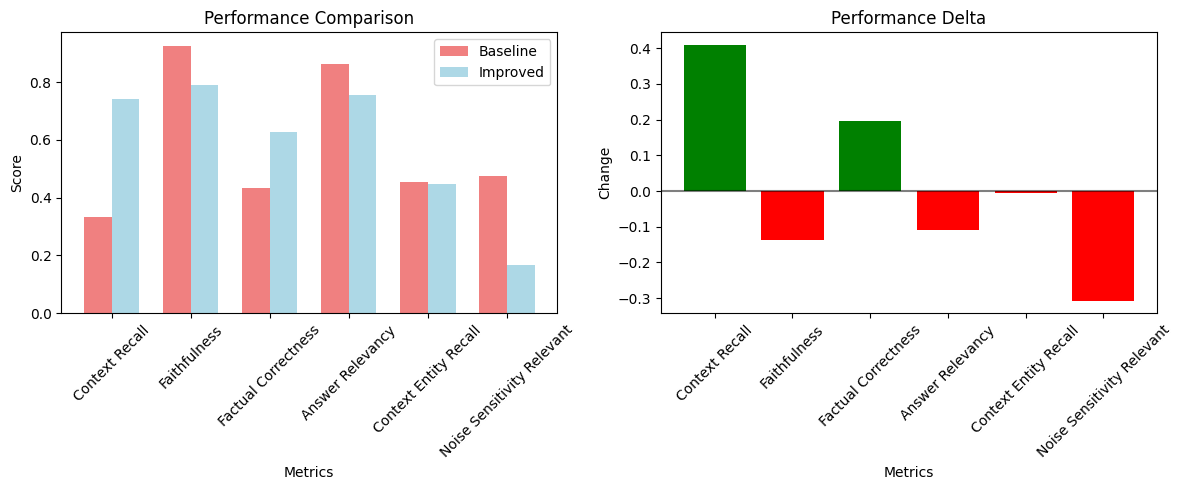

In [8]:
# Define the first run metrics for AI Job Market Assistant baseline
first_run = {
    'context_recall': 0.3333,
    'faithfulness': 0.9261,
    'factual_correctness': 0.4320,
    'answer_relevancy': 0.8623,
    'context_entity_recall': 0.4540,
    'noise_sensitivity_relevant': 0.4740
}

# Define the second run metrics for AI Job Market Assistant improved version
second_run = {
    'context_recall': 0.7417,
    'faithfulness': 0.7903,
    'factual_correctness': 0.6270,
    'answer_relevancy': 0.7540,
    'context_entity_recall': 0.4490,
    'noise_sensitivity_relevant': 0.1676
}

def calculate_metric_delta(run1: dict, run2: dict) -> dict:
    """
    Calculate the delta between two metric runs for AI Job Market Assistant.
    A positive delta means run2 is higher than run1.

    Args:
        run1 (dict): First run metrics
        run2 (dict): Second run metrics

    Returns:
        dict: Delta values for each metric
    """
    if not run1.keys() == run2.keys():
        raise ValueError("Both runs must contain the same metrics")

    delta = {}
    for metric in run1:
        delta[metric] = round(run2[metric] - run1[metric], 4)
    return delta

delta = calculate_metric_delta(first_run, second_run)

# Print results
for metric, value in delta.items():
    print(f"{metric}: {value:+.4f}")

# Create comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Performance comparison
metrics = list(first_run.keys())
baseline_values = [first_run[m] for m in metrics]
improved_values = [second_run[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

ax1.bar(x - width/2, baseline_values, width, label='Baseline', color='lightcoral')
ax1.bar(x + width/2, improved_values, width, label='Improved', color='lightblue')
ax1.set_xlabel('Metrics')
ax1.set_ylabel('Score')
ax1.set_title('Performance Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels([m.replace('_', ' ').title() for m in metrics], rotation=45)
ax1.legend()

# Performance delta
delta_values = [delta[m] for m in metrics]
colors = ['green' if x > 0 else 'red' for x in delta_values]
ax2.bar(range(len(metrics)), delta_values, color=colors)
ax2.set_xlabel('Metrics')
ax2.set_ylabel('Change')
ax2.set_title('Performance Delta')
ax2.set_xticks(range(len(metrics)))
ax2.set_xticklabels([m.replace('_', ' ').title() for m in metrics], rotation=45)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()